In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import time

import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn import linear_model
from sklearn import ensemble
from sklearn import naive_bayes

from linearmodels import PanelOLS
from linearmodels import OLS



import pickle

import psis
import stan_utility
import pystan

import statsmodels.formula.api as smf

from imblearn.under_sampling import RandomUnderSampler

import matplotlib as mpl    
mpl.rc('font',family='serif')

In [2]:
colors = sns.palettes.color_palette(palette = "hls", n_colors = 2)
colors

[(0.86, 0.3712, 0.33999999999999997),
 (0.33999999999999997, 0.8287999999999999, 0.86)]

In [3]:
def my_import():
    
    # Still including terror attacks...
    df = pd.read_csv("interpolated_df.csv", index_col= 0)

    ucdp = pd.read_csv("/home/polichinel/Dropbox/KU/9.semester/friopgave/data/upsala/ged181.csv")# the error is not importent as you do not use that feature 
    ucdp =  ucdp[ucdp['gwnob'].isna()] # only conflicts NOT between to stats
    ucdp_agg = ucdp.groupby(by = ['country_id','year'])[['best']].sum().reset_index()

    cow = pd.read_csv("COW country codes.csv")
    cow.rename(columns={'CCode' : 'country_id', 'StateAbb' : 'country'}, inplace = True)

    df.fillna(method = 'ffill', inplace = True)
    df.fillna(method = 'bfill', inplace = True)

    df_cow = df.merge(cow, on = ['country'], how = 'inner') # men hvordan kommer der flere?
    df_cow_ucdp_agg = df_cow.merge(ucdp_agg, on = ['country_id', 'year'], how = 'left')

    df_cow_ucdp_agg['best'].fillna(0, inplace = True)
    df_cow_ucdp_agg_lean = df_cow_ucdp_agg[['best','indegree_norm','outdegree_norm','degree_norm',
                                            'betweenness_dir_norm','center','downgrading','slope_indegree',
                                            'slope_outdegree','slope_degree', 'year','country_id',
                                            'Kcores_all','Kcores_in','Kcores_out']]
    
    df_cow_ucdp_agg_lean_1989 = df_cow_ucdp_agg_lean[df_cow_ucdp_agg_lean['year']>=1989]
    
    #tests:
    
#     net_set = set(df['country'].unique())
#     cow_set = set(cow['country'].unique())

#     print(set.difference(net_set,cow_set)) # nice!
    
#     ucdp_agg_set = set(ucdp_agg['country_id'].unique())
#     df_cow_set = set(df_cow['country_id'].unique())

#     print(set.difference(ucdp_agg_set,df_cow_set)) # south sudan.. fuk it.
    
    
    return(df_cow_ucdp_agg_lean_1989)

In [4]:
df = my_import()

df['binary_best'] = np.array(df['best'] > 0).astype('int')
df['lead_binary_best'] = df.sort_values('year').groupby(['country_id'])['binary_best'].shift(-1)
df['lead_best'] = df.sort_values('year').groupby(['country_id'])['best'].shift(-1)

df.dropna(inplace = True) # due to the leading

df["year_indicator_all"] = pd.get_dummies(df['year']).values.argmax(1)+1


df_conf_sub = df[df['best']>0]

quan_15 = df['degree_norm'].quantile(0.15)

df_deg_sub = df[df['degree_norm']>quan_15]



/home/polichinel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [5]:
df.columns


Index(['best', 'indegree_norm', 'outdegree_norm', 'degree_norm',
       'betweenness_dir_norm', 'center', 'downgrading', 'slope_indegree',
       'slope_outdegree', 'slope_degree', 'year', 'country_id', 'Kcores_all',
       'Kcores_in', 'Kcores_out', 'binary_best', 'lead_binary_best',
       'lead_best', 'year_indicator_all'],
      dtype='object')

In [6]:
df['lead_binary_best'].sum()/df['lead_binary_best'].shape

array([0.24786689])

In [7]:
df_deg_sub['lead_binary_best'].sum()/df_deg_sub['lead_binary_best'].shape

array([0.28639678])

# A bit discribtive:

In [8]:
df.columns

Index(['best', 'indegree_norm', 'outdegree_norm', 'degree_norm',
       'betweenness_dir_norm', 'center', 'downgrading', 'slope_indegree',
       'slope_outdegree', 'slope_degree', 'year', 'country_id', 'Kcores_all',
       'Kcores_in', 'Kcores_out', 'binary_best', 'lead_binary_best',
       'lead_best', 'year_indicator_all'],
      dtype='object')

In [9]:
df_conf_sub = df[df['best']>0]
df_conf_sub_no_r = df_conf_sub[df_conf_sub['best']<20000]


def power_conf_plot(df=df):

    colors = sns.palettes.color_palette(palette = "hls", n_colors = 2)

    plt.figure(figsize=[9,3])

    x1 = df['indegree_norm']
    x2 = df['outdegree_norm']
    x3 = df['betweenness_dir_norm']

    y = np.log(df['best']+1)
    #y = df['best']+1


    plt.plot(x1,y,'o',color=colors[0], label = '', alpha=0.1)
    plt.plot(x2,y,'o',color=colors[1], label = '', alpha=0.1)
    plt.plot(x3,y,'o',color='purple', label = '', alpha=0.1)


    slope, intercept, r_value, p_value, std_err = stats.linregress(x1,y)
    line1 = slope*y+intercept

    slope, intercept, r_value, p_value, std_err = stats.linregress(x2,y)
    line2 = slope*y+intercept

    slope, intercept, r_value, p_value, std_err = stats.linregress(x3,y)
    line3 = slope*y+intercept

#     label = 'Slope = ' + str(round(slope,3)) + \
#     '\n' + 'Intercept = ' + str(round(intercept,3)) + \
#     '\n' + 'R² = ' + str(round(r_value,3)) +\
#     '\n' + 'P_values < : ' + str(round(p_value,3)) +\
#     '\n' + 'Śtd_err = ' + str(round(std_err,3))

    plt.plot(y, line1, '-', alpha = 1, color = colors[0], label = 'indegree_norm')#, label = label)
    plt.plot(y, line2, '-', alpha = 1, color = colors[1], label = 'outdegree_norm')#, label = label)
    plt.plot(y, line3, '-', alpha = 1, color = 'purple', label = 'outdegree_norm')#, label = label)


    plt.xlim(-.01,1)
    plt.ylim(-.3,14.000)

    #plt.title('Fatalities in Center vs. Periphery')

    sns.despine(left=True, bottom=True)
    plt.legend(frameon = False)

    fig_title = 'center_vs_perifery.pdf'
    plt.savefig(fig_title, bbox_inches="tight")

    plt.show()

In [10]:
def power_conf_plot(df=df, fig_title = 'conflict_n_centrality.pdf', xlabel_list = False):

    colors = sns.palettes.color_palette(palette = "hls", n_colors = 2)
    colors.append('purple')
    
    fig = plt.figure(figsize=[9,9])
    
    f_list  = ['indegree_norm','outdegree_norm','betweenness_dir_norm']
    
    x_list = []
    
    for f in f_list:
        x_list.append(df[f])
    
    
    y = np.log(df['lead_best']+1)
    #y = df['best']+1
    
    
    for i in np.arange(len(x_list)):
        
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_list[i],y)

        
        line=(slope*x_list[i]+intercept)
        
        label = 'Slope = ' + str(round(slope,3)) + \
        '\n' + 'Intercept = ' + str(round(intercept,3)) + \
        '\n' + 'R² = ' + str(round(r_value**2,3)) +\
        '\n' + 'P_values = : ' + str(round(p_value,3)) +\
        '\n' + 'Śtd_err = ' + str(round(std_err,3))
        
    
        fig.subplots_adjust(hspace = 0.4, wspace = 0.3)
        #plt.title('test')
        
        plot_n = i+1
        
        plt.subplot(3,1,plot_n)

        plt.plot(x_list[i],y,'o',color=colors[i], label = '', alpha=0.1)
        plt.plot(x_list[i], line, '-', alpha = 1, color = colors[i], label = label) #, label = label_list[i])#, label = label)
        
        
        if xlabel_list == False:
            plt.xlabel(f_list[i])
        
        else:
            plt.xlabel(xlabel_list[i])
        
        
        plt.ylabel('log(Fatalities)')
        
        plt.legend(frameon = False)


    sns.despine(left=True, bottom=True)

    plt.savefig(fig_title, bbox_inches="tight")
        
    plt.show()

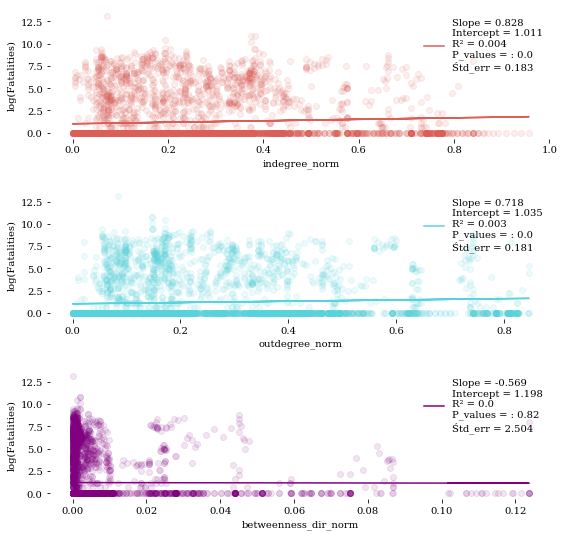

In [11]:
power_conf_plot()

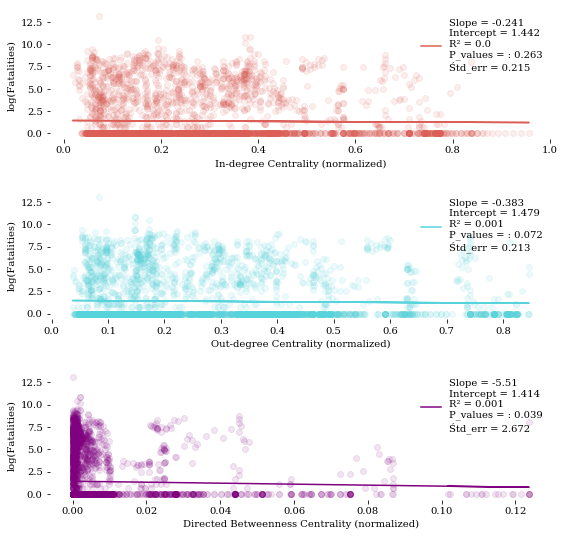

In [12]:
power_conf_plot(df_deg_sub, fig_title = 'degree_n_centrality_degree_sub.pdf', xlabel_list= ['In-degree Centrality (normalized)','Out-degree Centrality (normalized)','Directed Betweenness Centrality (normalized)'] )

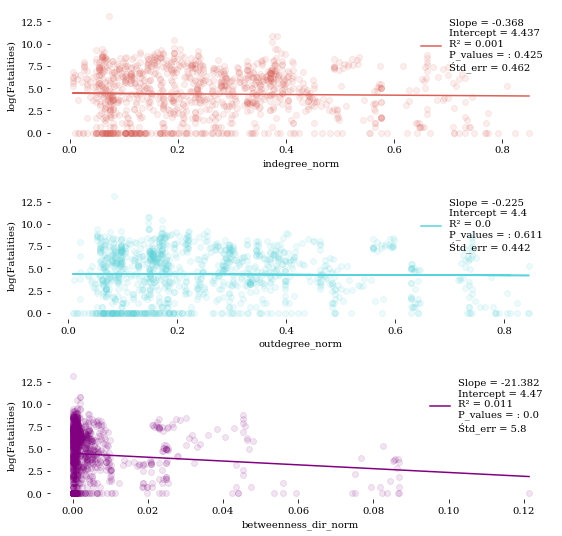

In [13]:
power_conf_plot(df_conf_sub, fig_title = 'conflict_n_centrality_conf_sub.pdf')

# Changing everything by change df!


In [14]:
df = df_deg_sub.copy()

In [15]:
def center_pef_dis(df=df, fig_title = 'center_vs_perifery.pdf'):
    
    colors = sns.palettes.color_palette(palette = "hls", n_colors = 2)

    plt.figure(figsize=[9,3])
    
    y1 = np.log(df[df['center']==0].groupby('year')['best'].mean()+1)
    y2 = np.log(df[df['center']==1].groupby('year')['best'].mean()+1)
    x = df['year'].unique()

    plt.plot(x,y1,'-o',color=colors[0], label = 'Periphery')
    plt.plot(x,y2,'-o',color=colors[1], label = 'Center')
    
    sns.despine(left=True, bottom=True)
    
    plt.xlabel('Year\n(With Liner Interpolation)')
    plt.ylabel('Mean Yearly Conflict Fatalities (logged)')
    
    plt.title('Fatalities in Center vs. Periphery')
    
    plt.legend(frameon = False)
    
    plt.savefig(fig_title, bbox_inches="tight")
    
    plt.show()
    


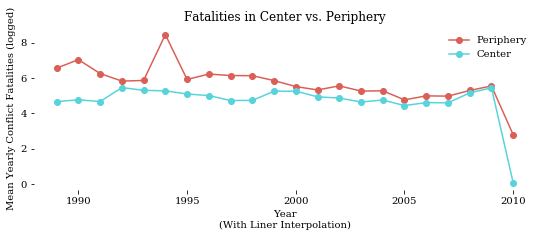

In [16]:
center_pef_dis()

# demeaning

In [17]:
def demeaning(df = df, feature = 'indegree_norm'):
    new_feature_name = feature + "_demeaned"
    
    country_mean = df.groupby('country_id')[feature].transform(np.mean)
    year_mean =  df.groupby('year')[feature].transform(np.mean)
    
    demeaned_feature = df[feature] - ( country_mean + year_mean )
    
    df[new_feature_name] = demeaned_feature 
    
#------------------------------------------------------------------------------------------------------------------


negative_list = ['best','year', 'country_id', 'binary_best', 'lead_binary_best', 'year_indicator_all', 'intercept']

for i in df.columns:
    if i not in negative_list:
        demeaning(feature = i)

# ML

Skal bruges et helt andet sted, men ikke her...

## Pooled

In [37]:
X = df[['indegree_norm','downgrading','slope_degree',
        'outdegree_norm','degree_norm','center',
        'slope_indegree','slope_outdegree',
        'betweenness_dir_norm','Kcores_all','Kcores_in','Kcores_out']]

y = np.log(df['lead_best']+1)


time_start = time.time()

sfs_f = sfs(estimator = linear_model.LinearRegression(), k_features= 'best', forward = True, verbose = 2, scoring = 'neg_mean_squared_error', cv = 10, n_jobs = 6)

sfs_f = sfs_f.fit(X,y)


time_stop = time.time()
time_to_finish = time_stop - time_start

print('\nminutes it took: {}\n'. format(time_to_finish/60))

[Parallel(n_jobs=6)]: Done   8 out of  12 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:    0.3s finished

[2018-12-08 11:55:00] Features: 1/12 -- score: -5.773455688199157[Parallel(n_jobs=6)]: Done   6 out of  11 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=6)]: Done  11 out of  11 | elapsed:    0.3s finished

[2018-12-08 11:55:00] Features: 2/12 -- score: -5.68917048914749[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.5s finished

[2018-12-08 11:55:01] Features: 3/12 -- score: -5.679700394949523[Parallel(n_jobs=6)]: Done   3 out of   9 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=6)]: Done   9 out of   9 | elapsed:    0.3s finished

[2018-12-08 11:55:01] Features: 4/12 -- score: -5.694253507840347[Parallel(n_jobs=6)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=6)]: Done   8 out of   8 | elapsed:    0


minutes it took: 0.07999894221623739



[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished

[2018-12-08 11:55:04] Features: 11/12 -- score: -6.027686658787211[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2018-12-08 11:55:04] Features: 12/12 -- score: -6.02768665878721

In [38]:
def first_best(selector = sfs_f):

    result = 0

    for i in np.arange(1,len(selector.k_feature_idx_)+1):

        if selector.get_metric_dict()[i]['avg_score'] < result: # > if not a neg score, ex AUC_score

            result = selector.get_metric_dict()[i]['avg_score']
            feature_index = selector.get_metric_dict()[i]['feature_idx']
            feature_names = selector.get_metric_dict()[i]['feature_names']
            n_features = len(feature_index)

        else:
            break
     
    return([n_features,result,feature_index,feature_names])

In [39]:
best_set = first_best(selector = sfs_f)
best_set

[1, -5.773455688199157, (6,), ('slope_indegree',)]

In [40]:
def plot_seq_fs():

    list_of_means = []
    list_of_std_dev = []
    list_of_n = []

    for i in np.arange(1,len(sfs_f.get_metric_dict())+1):

        list_of_means.append(sfs_f.get_metric_dict()[i]['cv_scores'].mean())
        list_of_std_dev.append(sfs_f.get_metric_dict()[i]['std_dev']) # but why is it not 2*std_err?
        list_of_n.append(i)

    colors = sns.palettes.color_palette(palette = "hls", n_colors = 2)    

    plt.figure(figsize=[15,5])    

    x = np.array(list_of_n)
    y = np.array(list_of_means)

    y_upper = y + np.array(list_of_std_dev) # * 2) 
    y_lower = y - np.array(list_of_std_dev) #* 2)

    plt.plot(x,y, '-o' ,color = colors[1])
    #plt.plot(x, y_upper, x, y_lower, color=colors[1], alpha = 0.4)

    plt.fill_between(x, y_lower, y_upper, color='lightgrey', alpha = 0.4, label = '95% Confidence Interval')

    plt.vlines(best_set[0], y_lower.min(), y_upper.max() , colors[0], 'dashed', alpha = 0.8, label = 'Optimal N of Features')
    
    plt.ylim(y_lower.min()*2,y_upper.max()/2)
    
    plt.ylabel('Metric')
    plt.xlabel('Number of Features')
    plt.title('Sequential (Forward) Feature Selection')

    sns.despine(left = True, bottom = True)
    plt.legend(frameon = False)
    plt.show()

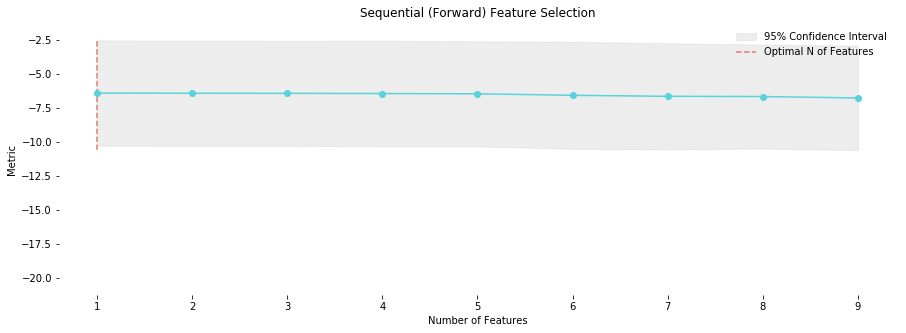

In [22]:
plot_seq_fs() #fint, men ikke lige til at aflæse. Så der for måske en lin_prop?

# Demeaned

In [41]:
X = df[['indegree_norm_demeaned','downgrading_demeaned','slope_degree_demeaned',
        'outdegree_norm_demeaned','degree_norm_demeaned','center_demeaned',
        'slope_indegree_demeaned','slope_outdegree_demeaned',
        'betweenness_dir_norm_demeaned','Kcores_all','Kcores_in','Kcores_out']]

y = np.log(df['lead_best']+1)


time_start = time.time()

sfs_f = sfs(estimator = linear_model.LinearRegression(), k_features= 'best', forward = True, verbose = 2, scoring = 'neg_mean_squared_error', cv = 10, n_jobs = 6)

sfs_f = sfs_f.fit(X,y)


time_stop = time.time()
time_to_finish = time_stop - time_start

print('\nminutes it took: {}\n'. format(time_to_finish/60))


[Parallel(n_jobs=6)]: Done   8 out of  12 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:    0.3s finished

[2018-12-08 11:55:23] Features: 1/12 -- score: -5.782915457720241[Parallel(n_jobs=6)]: Done   6 out of  11 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=6)]: Done  11 out of  11 | elapsed:    0.3s finished

[2018-12-08 11:55:23] Features: 2/12 -- score: -5.783816903520618[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s finished

[2018-12-08 11:55:24] Features: 3/12 -- score: -5.786323104874339[Parallel(n_jobs=6)]: Done   3 out of   9 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=6)]: Done   9 out of   9 | elapsed:    0.4s finished

[2018-12-08 11:55:24] Features: 4/12 -- score: -5.786323104874337[Parallel(n_jobs=6)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=6)]: Done   8 out of   8 | elapsed:    


minutes it took: 0.07697954177856445




[2018-12-08 11:55:27] Features: 11/12 -- score: -5.83312990602474[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2018-12-08 11:55:27] Features: 12/12 -- score: -5.832875937752197

In [42]:
best_set = first_best(selector = sfs_f)
best_set

[1, -5.782915457720241, (10,), ('Kcores_in',)]

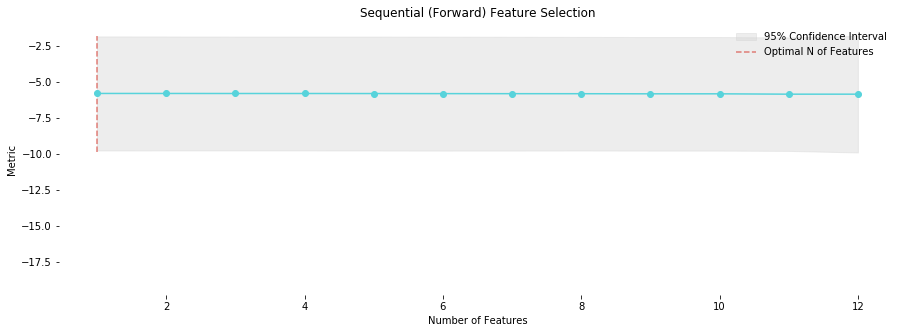

In [43]:
plot_seq_fs() #fint, men ikke lige til at aflæse. Så der for måske en lin_prop?

Så det her er også den vej du går med den anden opgave.

# Regression:

# Checking all with lead best lin-log model:

## pooled Ols

In [44]:
x_list = ['slope_degree','downgrading','center','outdegree_norm', 'degree_norm',
          'indegree_norm','slope_indegree','slope_outdegree',
          'betweenness_dir_norm','Kcores_all','Kcores_in','Kcores_out']


panel_data = df[['slope_degree','downgrading','center','outdegree_norm', 'degree_norm','betweenness_dir_norm',
                 'indegree_norm', 'country_id','year','lead_best','best','lead_binary_best','slope_indegree','slope_outdegree']]

panel_data.set_index(['country_id', 'year'], inplace=True)

y = np.log(panel_data['lead_best']+1)

#y = np.log(df['lead_best']+1)


for x_name in x_list:
    x = df[[x_name]].copy()
    x['intercept'] = 1
    mod = OLS(y, x)
    res = mod.fit()
    print(res)


                            OLS Estimation Summary                            
Dep. Variable:              lead_best   R-squared:                      0.0097
Estimator:                        OLS   Adj. R-squared:                 0.0095
No. Observations:                4688   F-statistic:                    26.319
Date:                Sat, Dec 08 2018   P-value (F-stat)                0.0000
Time:                        11:55:49   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                               
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------
slope_degree    -4.3072     0.8396    -5.1302     0.0000     -5.9527     -2.6616
intercept        1.2729     0.0391     32.51

## Demeaned - just a test..

In [27]:
x_list = ['slope_degree_demeaned','indegree_norm_demeaned', 'outdegree_norm_demeaned',
       'degree_norm_demeaned', 'betweenness_dir_norm_demeaned',
       'center_demeaned', 'downgrading_demeaned', 'slope_indegree_demeaned',
       'slope_outdegree_demeaned']

y = np.log(df['lead_best']+1)


country_mean = df.groupby('country_id')['slope_degree'].transform(np.mean)
year_mean =  df.groupby('year')['slope_degree'].transform(np.mean)

#     x = df[['slope_degree']].copy()
#     x['country_mean'] = country_mean
#     x['year_mean'] = year_mean
    
x = df[['slope_degree_demeaned']].copy()
    
#x['mean'] = country_mean + year_mean
x['intercept'] = 1 # du kommer tæt på med intercept.. men der er stadigt noget glat.... 
#gtå fint med vær slags alene. 
#og det er det samme on de includeres i modellen eller tærkkes fra først.....

mod = OLS(y, x)
res = mod.fit()
print(res)

                            OLS Estimation Summary                            
Dep. Variable:              lead_best   R-squared:                      0.0003
Estimator:                        OLS   Adj. R-squared:              7.775e-05
No. Observations:                3977   F-statistic:                    0.9910
Date:                Fri, Dec 07 2018   P-value (F-stat)                0.3195
Time:                        18:10:21   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                                   Parameter Estimates                                   
                       Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------
slope_degree_demeaned     1.1280     1.1331     0.9955     0.3195     -1.0929      3.3488
intercep

## Panal:

In [47]:
panel_data = df[['slope_degree','downgrading','center','outdegree_norm', 
                 'degree_norm','betweenness_dir_norm','indegree_norm', 
                 'country_id','year','lead_best','best','lead_binary_best',
                 'slope_indegree','slope_outdegree',
                 'Kcores_all','Kcores_in','Kcores_out']]

panel_data.set_index(['country_id', 'year'], inplace=True)

x_list = ['slope_degree','downgrading','center','outdegree_norm', 'degree_norm',
          'indegree_norm','slope_indegree','slope_outdegree',
          'betweenness_dir_norm','Kcores_all','Kcores_in','Kcores_out']


#y = panel_data['lead_binary_best']
y = np.log(panel_data['lead_best']+1)


for x_name in x_list:
    x = panel_data[x_name]
    mod = PanelOLS(y, x, entity_effects=True, time_effects=True)
    res = mod.fit(cov_type='clustered', cluster_entity=True)
    print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:              lead_best   R-squared:                        0.0006
Estimator:                   PanelOLS   R-squared (Between):              0.0028
No. Observations:                4688   R-squared (Within):              -0.0017
Date:                Sat, Dec 08 2018   R-squared (Overall):              0.0017
Time:                        11:57:35   Log-likelihood                   -7636.1
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2.7844
Entities:                         196   P-value                           0.0953
Avg Obs:                       23.918   Distribution:                  F(1,4470)
Min Obs:                       21.000                                           
Max Obs:                       43.000   F-statistic (robust):             0.5685
                            

# Only conflict countries:
Så det her er om der - inde i conflict lande - er en sammenhæng mellem netwærks metrics og mængden af døde næste år..

In [51]:
panel_data = df_conf_sub[['slope_degree','downgrading','center','outdegree_norm', 'degree_norm','betweenness_dir_norm',
                 'indegree_norm', 'country_id','year','lead_best','best','lead_binary_best','slope_indegree','slope_outdegree']]

panel_data.set_index(['country_id', 'year'], inplace=True)
x = panel_data[['slope_indegree','center']]
#y = panel_data['lead_binary_best']

x_list = ['slope_degree','downgrading','center','outdegree_norm', 'degree_norm',
                 'indegree_norm','slope_indegree','slope_outdegree','betweenness_dir_norm']


y = np.log(panel_data['lead_best']+1)


for x_name in x_list:
    x = panel_data[x_name]
    mod = PanelOLS(y, x, entity_effects=True, time_effects=True)
    res = mod.fit(cov_type='clustered', cluster_entity=True)
    print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:              lead_best   R-squared:                        0.0035
Estimator:                   PanelOLS   R-squared (Between):              0.0083
No. Observations:                1173   R-squared (Within):              -0.0030
Date:                Fri, Dec 07 2018   R-squared (Overall):              0.0036
Time:                        11:39:03   Log-likelihood                   -2382.3
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3.6644
Entities:                         104   P-value                           0.0559
Avg Obs:                       11.279   Distribution:                  F(1,1047)
Min Obs:                       1.0000                                           
Max Obs:                       43.000   F-statistic (robust):             2.2075
                            

# SLET:

# pystan:

In [16]:
compiled_model1 = stan_utility.compile_model('model1.stan')

Using cached StanModel


In [17]:
list(best_set[3])

['indegree_norm', 'downgrading', 'slope_degree']

In [18]:
def gen_data_list(df=df, X_list = ['slope_degree']):
    
    
    N_obs = df.shape[0]
    N_countries  = len(df['country_id'])
    country_id = df['country_id'].astype(int)
    N_years = len(df['year'])
    year_indicator = df['year_indicator_all']
    
    y = df['lead_binary_best'].astype(int)

    X = df[X_list]
    K_col = X.shape[1]
    
    data_list = dict(X = X,
                 #X_pred = X2_test,
                 y = y,
                 N = N_obs,
                 #N_pred = N_obs_test,
                 K = K_col,
                 J = N_countries,
                 C = country_id,
                 #C_pred = country_indicator_test,
                 M = N_years,
                 T = year_indicator)
           
           
    return(data_list)

In [19]:
# make a loop:
data_list0 = gen_data_list(X_list = [best_set[3][0]])
data_list1 = gen_data_list(X_list = [best_set[3][1]])
data_list2 = gen_data_list(X_list = [best_set[3][2]])
data_list3 = gen_data_list(X_list= list(best_set[3]))

In [20]:
time_start = time.time()
# ----------------------------------------------------------------------------
stan_model0 = compiled_model1.sampling(data=data_list0, seed=123)

with open("model0_fit.pkl", "wb") as f:
    pickle.dump({'model' : compiled_model1, 'fit' : stan_model0}, f, protocol=-1)
f.close()

print("one done")


# ----------------------------------------------------------------------------

stan_model1 = compiled_model1.sampling(data=data_list1, seed=123)

with open("model1_fit.pkl", "wb") as f:
    pickle.dump({'model' : compiled_model1, 'fit' : stan_model1}, f, protocol=-1)
f.close()

print("two done")


# ----------------------------------------------------------------------------

stan_model2 = compiled_model1.sampling(data=data_list2, seed=123)

with open("model2_fit.pkl", "wb") as f:
    pickle.dump({'model' : compiled_model1, 'fit' : stan_model2}, f, protocol=-1)
f.close()

print("three done")


# ----------------------------------------------------------------------------

stan_model3 = compiled_model1.sampling(data=data_list3, seed=123)

with open("model3_fit.pkl", "wb") as f:
    pickle.dump({'model' : compiled_model1, 'fit' : stan_model3}, f, protocol=-1)
f.close()

print("All done")

time_end = (time.time() - time_start)/60
print("minutes in took to finish: {}".format(time_end))

/home/polichinel/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/polichinel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  


one done


/home/polichinel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.


two done


/home/polichinel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.


three done


/home/polichinel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.


All done
minutes in took to finish: 218.5672983964284


In [21]:
# # Lead pickles is applicable..

# with open("model0_fit.pkl", "rb") as f:
#      data_dict = pickle.load(f)

# f.close()

# stan_model0 = data_dict['fit']


# with open("model1_fit.pkl", "rb") as f:
#      data_dict = pickle.load(f)

# f.close()

# stan_model1 = data_dict['fit']


# with open("model2_fit.pkl", "rb") as f:
#      data_dict = pickle.load(f)

# f.close()

# stan_model2 = data_dict['fit']


# with open("model3_fit.pkl", "rb") as f:
#      data_dict = pickle.load(f)

# f.close()

# stan_model3 = data_dict['fit']

In [130]:
def beta_plot(stan_model = stan_model0, beta_label = ''):

    plt.figure(figsize=[15,5])
    #colors = sns.palettes.color_palette(palette = "hls", n_colors = 2)  

    if len(stan_model["beta"].shape) == 1:
        colors = sns.palettes.color_palette(palette = "hls", n_colors = 2) 
        #beta_label = str(X.columns[0])
        sns.kdeplot(stan_model["beta"], label = beta_label, alpha = 0.8, color = colors[1])
        
        beta_est = stan_model["beta"].mean()
        
        plt.vlines(beta_est, 0, 1.5, 'darkblue', 'dashed')
        plt.text(beta_est * 1.1, 0.4, str(round(beta_est,3)))


    elif len(stan_model["beta"].shape) > 1:
        
        colors = sns.palettes.color_palette(palette = "hls", n_colors = stan_model["beta"].shape[1])
    
        for i in range(stan_model["beta"].shape[1]):
            beta_label =  "beta " + str(i+1) +" "+ str(X.columns[i])
            sns.kdeplot(stan_model["beta"][:,i], label = beta_label, alpha = 0.8, color = colors[i])
            
            beta_est = stan_model["beta"][:,i].mean()
            
            hight = 0.4 + (i/10)
        
            plt.vlines(beta_est, 0, 1.5,  colors[i], 'dashed')
            plt.text(beta_est * 1.1, hight, str(round(beta_est,3)), color = colors[i])
            
            
    
    else:
        print('Worng X')
    
    plt.vlines(0, 0, 1.5, 'darkred', 'dashed')



    # plt.xticks(x_ticks_range)
    # plt.ylim(y_border)
    # plt.xlim(x_border)   
    plt.title("model1")    
    sns.despine(left = True)
    # plt.grid()
    #plt.yticks([])
    plt.legend(frameon = False)
    plt.show()


    N_sim = len(stan_model1['beta'])

    print('Prop pos or neg:')
    prop_pos = np.sum(stan_model1["beta"]>=0)/N_sim
    print(prop_pos)


    print('Prop neg:')
    prop_pos = np.sum(stan_model1["beta"]<0)/N_sim
    print(prop_pos)

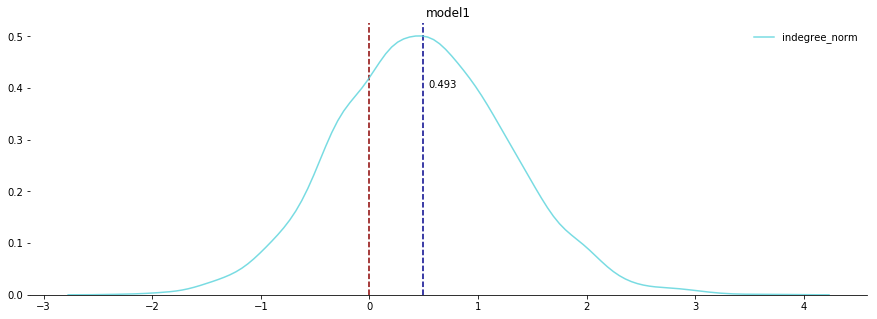

Prop pos or neg:
0.84075
Prop neg:
0.15925


In [118]:
beta_plot(stan_model0, beta_label=  best_set[3][0])

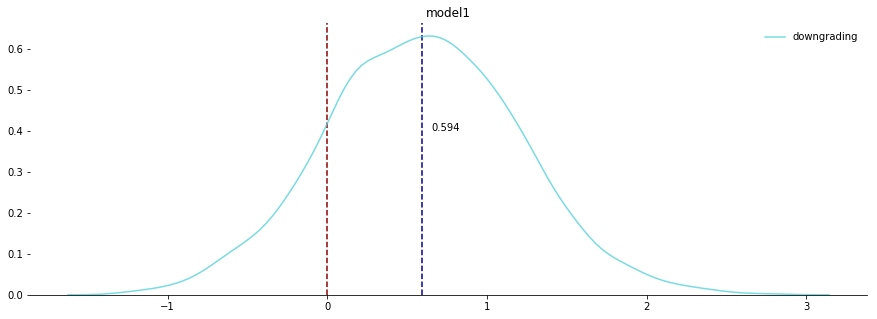

Prop pos or neg:
0.84075
Prop neg:
0.15925


In [119]:
beta_plot(stan_model1, beta_label= best_set[3][1])

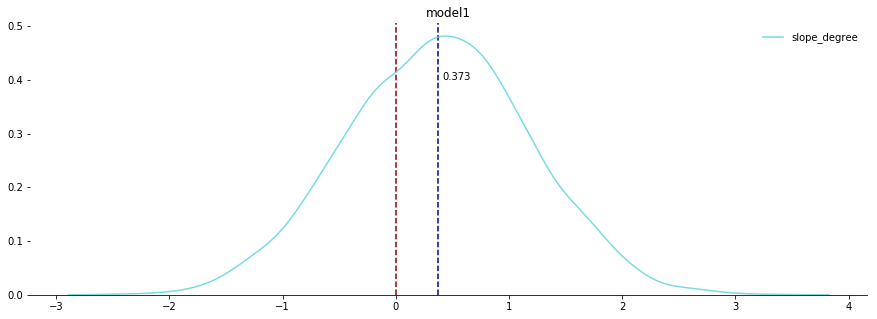

Prop pos or neg:
0.84075
Prop neg:
0.15925


In [120]:
beta_plot(stan_model2, beta_label= best_set[3][2])

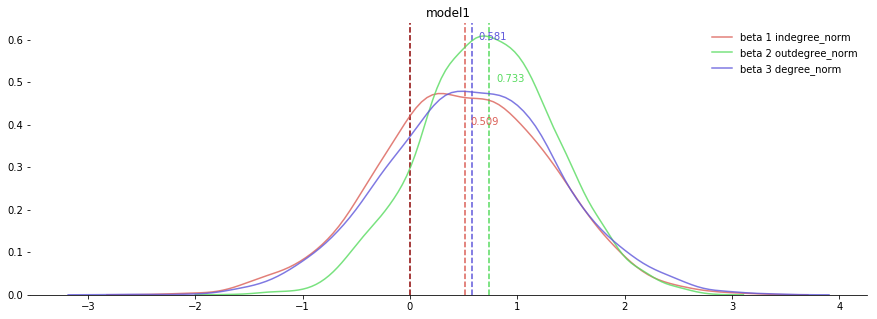

Prop pos or neg:
0.84075
Prop neg:
0.15925


In [131]:
beta_plot(stan_model3)